## Averaged flows


In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
import os
import sys
sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder
%matplotlib qt

experiment = "s19" 

def divergence_npgrad(flow):
    # flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dx = np.gradient(Fx, axis=0)
    dFy_dy = np.gradient(Fy, axis=1)
    return dFx_dx + dFy_dy


def analyze_defects(img):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, 25)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf



# Defect dynamics time lapse

## Make dataframe with all defects and save as csv

In [61]:
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])

PLOT = True

# image_list = glob.glob(r"C:/Users/victo/Downloads/SB_lab/RPE1_C2C12_/Test001/*.tif")
image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[20:120:1]

if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_axis_off()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

    # u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
    # v = np.zeros_like(u)


for im1, im2 in zip(image_list[:-1], image_list[1:]):
    print(os.path.basename(im1))
    img1 = cv2.imread(im1)[:,:,0]
    
    # calculate velocity and plot fields
    if PLOT:
        ax.clear()
        img2 = cv2.imread(im2)[:,:,0]
        flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
            winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)  
        # >> uncomment to have average flow representation
        # >>  TO DO devide by number of frames
        # u += flow[..., 0]
        # v += flow[..., 1]
        # flow = np.stack((u, v), axis=-1)

        divergence = gaussian_filter(divergence_npgrad(flow), sigma=30)

        # Apply Contrast Limited Adaptive Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(255-img_clahe, "gray")
        ax.imshow(divergence, "jet", alpha=.3, vmin=-0.03, vmax=0.03)

    ori, plushalf, minushalf = analyze_defects(img1)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_t")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)
    
    if PLOT:
        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
    
    
        save_path = os.path.join(
            r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
            experiment,
            'Nematic', 
            os.path.splitext(os.path.basename(im1))[0]
            )
    
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))
    # break    

minushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/MinusHalf1.csv")
plushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusHalf1.csv")

RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t21.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t22.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t23.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t24.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t25.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t26.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t27.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t28.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t29.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t30.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t31.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t32.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t33.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t34.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t35.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t36.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t37.T

In [62]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusHalf1.csv')

In [63]:
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()

fig, ax = plt.subplots(1,1, figsize=(12,12))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.tight_layout()
white_frame = np.ones((2048,2048,3))

for f in frames:
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    # ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
        experiment,
        'Nematic2',
        'frame_' + str(f) + ".png"
        )
    # break
    ax.set_xlim([0, 2048])
    ax.set_ylim([0, 2048])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))             


    # break



## Import CSVs

In [140]:
first_frame, last_frame

(101, 199)

In [158]:
experiment = "s14" 

minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusTM_spots.csv', skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders
last_frame = minushalf_df["frame"].max() # Validate this number in image folders

print("  ////////    PLUS   //////////")
print([(plushalf_TM[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

  ////////    PLUS   //////////
[(83, 20), (83, 20), (77, 20), (78, 20), (73, 20), (73, 20), (73, 20), (69, 20), (71, 20), (66, 20)]
[(83, 10), (83, 10), (77, 10), (78, 10), (73, 10), (73, 10), (73, 10), (70, 10), (71, 10), (66, 10)]

 ////////    MINUS   //////////
[(82, 20), (80, 20), (79, 20), (78, 20), (72, 20), (70, 20), (72, 20), (70, 20), (71, 20), (64, 20)]
[(82, 10), (80, 10), (79, 10), (78, 10), (72, 10), (70, 10), (72, 10), (70, 10), (71, 10), (64, 10)]


## Find shift and rescale

slope: 2.2158362658984307 | intercept: -161.03423610717925
slope: 2.2158362658984307 | intercept: -161.03423610717925
slope: 2.215913153503683 | intercept: -161.08011350180263
-------  X  ------------
slope: 2.216268980773293 | intercept: -152.2695712848465
slope: 2.216268980773293 | intercept: -152.2695712848465
slope: 2.2162530683878185 | intercept: -152.21589474138142
-------  Y  ------------


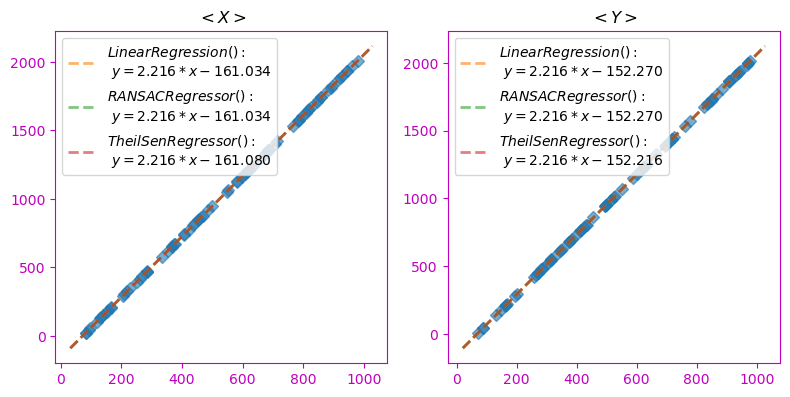

In [159]:
from sklearn import linear_model

%matplotlib inline
frame = 1

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax,dd in zip(axs, dims):
    ave_slope, ave_intercept = 0, 0

    X = plushalf_TM["POSITION_"+dd.upper()][plushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = plushalf_df[dd][plushalf_df["frame"]==first_frame+frame].iloc[:]

    if dd=="y":
        y = (2048 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))   
         
        ave_slope += slope  
        ave_intercept += intercept

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

    slope_intercept[dd] = {"slope": ave_slope/len(lrs),
                             "intercept": ave_intercept/len(lrs)
                             }

    # ave_slope = ave_slope/len(lrs)
    # ave_intercept = ave_intercept/len(lrs)
plt.tight_layout()

### Validate shift and rescale

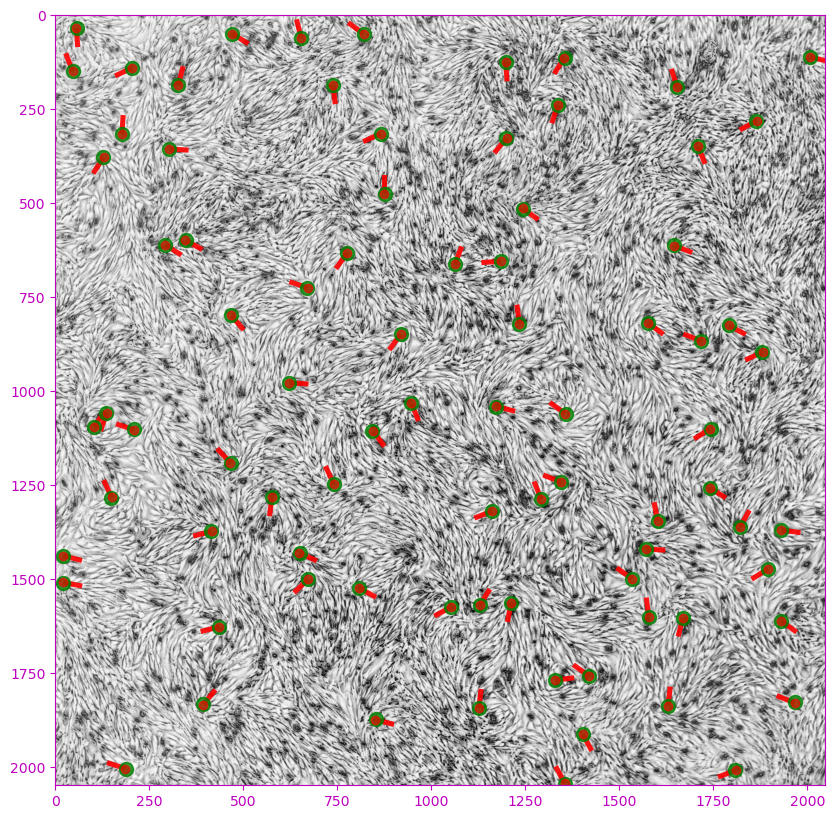

In [160]:
%matplotlib inline
SLOPEx = slope_intercept["x"]["slope"]
INTERCEPTx = slope_intercept["x"]["intercept"]
SLOPEy = slope_intercept["y"]["slope"]
INTERCEPTy = slope_intercept["y"]["intercept"]
frame = 1

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[0]

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusTM_spots.csv', skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusHalf1.csv')

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

### Apply angle information data to TrackMate DataFrame

In [161]:
%matplotlib qt
# SLOPEx = 2.2020369696888773
# INTERCEPTx = -153.5892752236614
# SLOPEy = 2.589611169431241
# INTERCEPTy = -152.43827493084723

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

# experiment = "s15" 

minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusTM_spots.csv', skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

In [162]:
# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


[[ 291.  612.]
 [1062.  662.]
 [1184.  654.]] 
 [[ 290.98629803  611.19062295]
 [1062.10623752  662.16468751]
 [1183.97864175  653.29963281]] 
 [[ 291.  612.]
 [1062.  662.]
 [1184.  654.]]
--------------
[[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]] 
 [[1624.93515888 1553.10268552]
 [1556.24344013 1555.3189492 ]
 [1101.99175164 1612.94180479]] 
 [[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]]
--------------


In [163]:
# replace and add angles
# plushalf_TM[['x_img1','y_img1','ang1','charge']] =  plushalf_df[['x', 'y', 'ang1', 'charge']].iloc[idx[:]].values

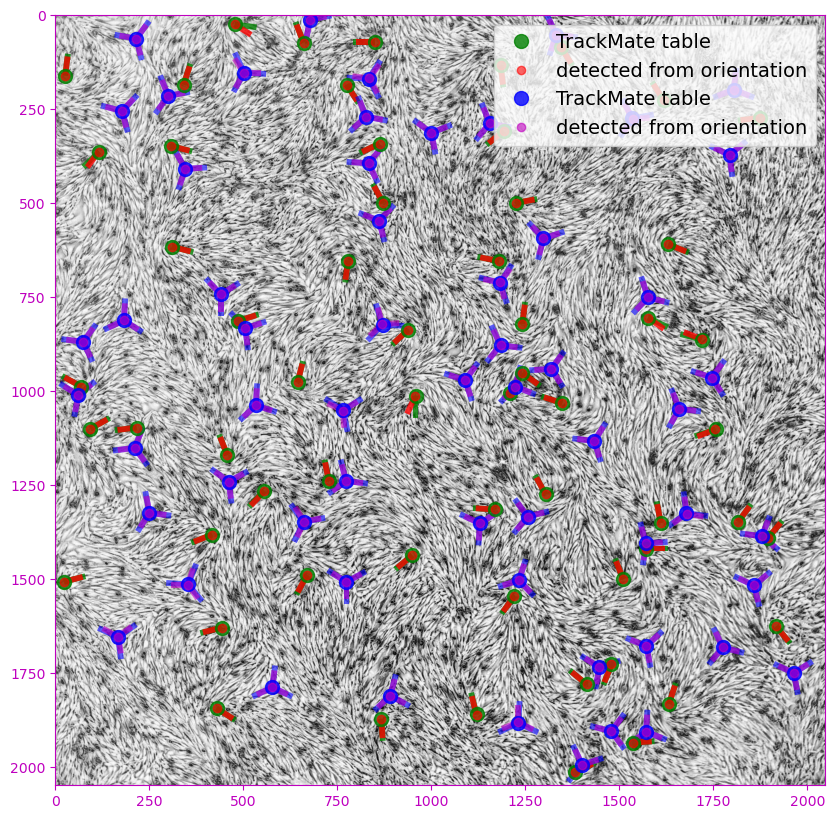

In [164]:
# test replaced values
%matplotlib inline
frame = 20

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==first_frame+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"], m_df["y"], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [165]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusAndMinusTM.csv")

# Start Here Find Pairs

In [261]:
experiment = "s19"
plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusAndMinusTM.csv")
plus_minus_df.head()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,ang2,ang3,charge
0,0,ID901391,901391,26.0,81.421509,657.0,88.0,0.0,0.0,0,...,0.973672,1.625018,1293.144897,1972.526759,1293.0,1972.0,2.073451,NaN,NaN,0.5
1,1,ID901390,901390,89.0,81.421509,860.0,86.0,0.0,0.0,0,...,0.973672,1.625018,1740.161345,1977.706022,1740.0,1978.0,0.000000,NaN,NaN,0.5
2,2,ID901405,901405,124.0,74.827904,242.0,205.0,0.0,0.0,0,...,0.977139,1.318006,379.293538,1669.539881,380.0,1670.0,-1.570796,NaN,NaN,0.5
3,3,ID901404,901404,35.0,81.421509,844.0,192.0,0.0,0.0,0,...,0.973672,1.625018,1704.928521,1703.205090,1705.0,1704.0,1.319469,NaN,NaN,0.5
4,4,ID901407,901407,34.0,81.421509,718.0,220.0,0.0,0.0,0,...,0.973672,1.625018,1427.470036,1630.695409,1427.0,1632.0,-1.759292,NaN,NaN,0.5


In [262]:
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)   


pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a piar (50)
    dist_tresh = dist<50
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values, 
        plus_xy["TRACK_ID"][dist_tresh].values
        ]) 

pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T).dropna().drop_duplicates()    

## Pair Trajectories

In [263]:
%matplotlib qt

def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["FRAME", "x_img1","y_img1", "ang1" ]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" ], axis=1)

minimal_track = 5

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
pair_stat = []
for (num,m), n in zip(enumerate(pairs_df[0]), pairs_df[1]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (5 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        mp_distance.append(((xm-xp)**2 + (ym-yp)**2)**.5)
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        # mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi 
        # m_ang = mp_angle - np.min(plus_minus_df["ang1"][p_idx],plus_minus_df["ang2"][p_idx],plus_minus_df["ang3"][p_idx])
        # p_ang = mp_angle - plus_minus_df["ang1"][p_idx]
        # pair_stat.append([mp_distance, m_ang, p_ang])
        # ax.quiver(xp, yp, np.cos(mp_angle), np.sin(mp_angle), alpha=.1)

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-np.median(mp_angle), thm-np.median(mp_angle)])

        for i in range(3):
            ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

        ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
        ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

        ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
        ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

        ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
        ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
        # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
        ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-np.median(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
        ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-np.median(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)

In [254]:
len(pair_stat)

38

In [255]:
mpangle = (angs[0]- angs[1])
np.median(np.min(mpangle %(2*np.pi), axis=0))
# mpangle

1.7907078125461822

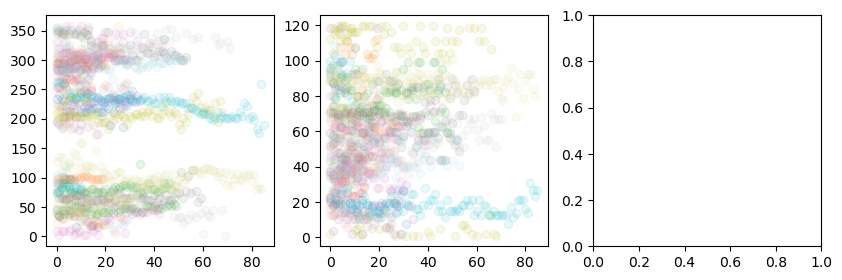

In [256]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(10,3))
colors = plt.cm.tab20(np.linspace(0, 1, num=len(pair_stat)))
plt.set_cmap('tab20')
pangles = []
mangles = []
mpangles = []
for num, angs in enumerate(pair_stat):
    # print(angs[0],angs[1])
    # ax[0].plot(np.arange(len(angs[0])), np.fmod(angs[0], 2*np.pi)*180/np.pi, "o", alpha=.1)
    # ax[1].plot(np.arange(len(angs[1])), np.fmod(angs[1], 2*np.pi)*180/np.pi, "o", alpha=.05)
    ax[0].plot(np.arange(len(angs[0])), angs[0] % (2*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)
    ax[1].plot(np.arange(len(angs[1][0])), angs[1][0] % (2/3*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)

    pangles.append(angs[0])
    mangles.append(np.concatenate(angs[1]))

    mpangle = np.min((angs[1] - angs[0]) %(2*np.pi), axis=0)#[-3:]
    mpangles.append(mpangle)

    # ax[2].plot(np.arange(len(mpangle)), np.array(mpangle) %(2/3*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)
    
    # if num>25:
    #     break

# plt.figure(figsize=(3,3))
# plt.hist(np.concatenate(mpangles) % (2/3*np.pi) *180/np.pi , alpha=.2, rwidth=.9)
# ax[0].set_ylim([-10,370])
# ax[1].set_ylim([-10,130])
# ax[1].set_ylim([0,120])

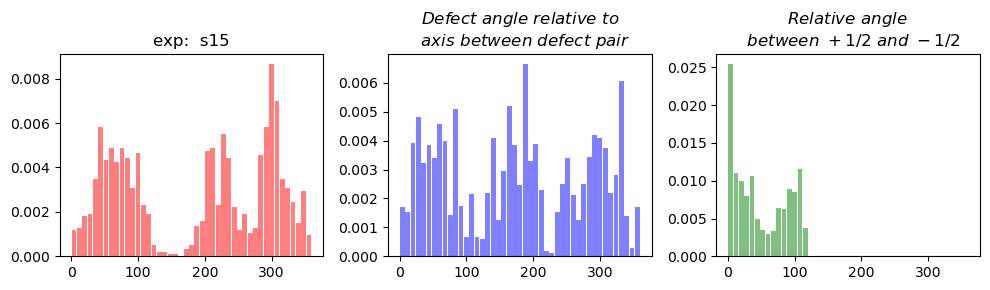

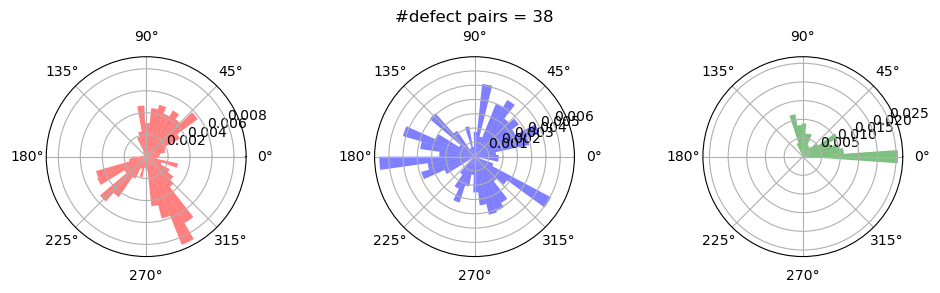

In [257]:
%matplotlib inline
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
pangle = np.concatenate(pangles) + 0 * 2*np.pi
mangle = np.concatenate(mangles) + 0 * 2/3*np.pi #2*np.pi * np.ones((1,100)).ravel() #
mpangle = np.concatenate(mpangles) + 0 * 2/3*np.pi
pangle = pangle % (2*np.pi)
mangle = mangle % (2*np.pi)
mpangle = mpangle % (2/3*np.pi)

fig1, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.set_title(r"exp:  " + experiment)
ax2.set_title("$Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair $")
ax3.set_title("$Relative ~angle$ \n $~between ~+1/2 ~and ~-1/2$")
pn, _, _ =  ax1.hist(pangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="red")
mn, _, _ = ax2.hist(mangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="blue")
mpn, _, _ =  ax3.hist(mpangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
plt.tight_layout()
fig1.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_hist_" + experiment +".png")


# plt.clf()
width = 2 * np.pi / bins_number
fig2, (ax1,ax2,ax3) = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(10,3))
ax1.bar(bins[:bins_number], pn, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], mn, color="blue",width=width, bottom=0.0, alpha=.5)
ax3.bar(bins[:bins_number], mpn, color="green",width=width, bottom=0.0, alpha=.5)
ax2.set_title(r"#defect pairs = " + str(len(pair_stat)))
plt.tight_layout()
fig2.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_polhist_" + experiment +".png")


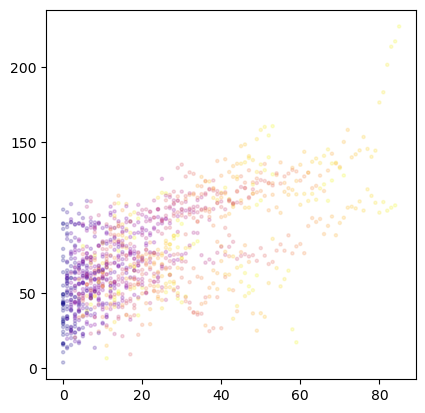

In [258]:
mp_distance_mat = np.zeros([len(mp_distance), len(max(mp_distance, key = lambda x: len(x)))])
mp_distance_mat[:] = np.nan
for i, dist in enumerate(mp_distance):
    # print(i, j)
    plt.scatter(np.arange(len(dist)), np.flip(dist), c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")
    mp_distance_mat[i,0:len(dist)] = np.flip(dist)
    
plt.gca().set_box_aspect(1)  

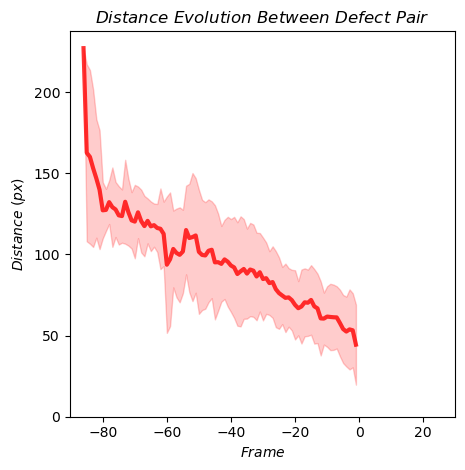

In [259]:
%matplotlib inline
for i in range(mp_distance_mat.shape[0]):
    y = mp_distance_mat[i,:][~np.isnan(mp_distance_mat[i,:])]
    # plt.scatter(np.arange(len(y)), y, c=np.arange(len(y)), s=3, alpha=.2, cmap="plasma")


mean, stdiv = np.flip(np.nanmean(mp_distance_mat, axis=0)), np.flip(np.nanstd(mp_distance_mat, axis=0))
max_frame = mp_distance_mat.shape[1]

plt.plot(np.arange(len(mean))-max_frame, mean, "r-", alpha=.8, linewidth=3)
plt.fill_between(np.arange(len(mean))-max_frame, mean-stdiv, mean+stdiv, color="red", alpha=.2)
plt.ylim([0,None])
plt.xlim([None,30])
plt.gca().set_box_aspect(1)  
plt.xlabel('$Frame$')
plt.ylabel(r'$Distance ~(px)$') #plt.ylabel('$Distance ~(\mu m)$')
plt.title(r'$Distance ~Evolution ~Between ~Defect ~Pair$')
plt.tight_layout()
plt.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/defect_pair_distance_" + experiment +".png")

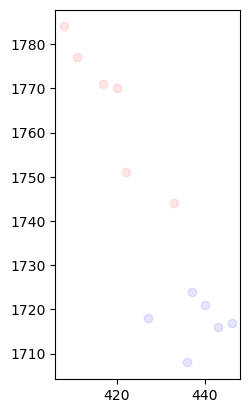

In [260]:
plt.plot(xp, yp,"ro", alpha=.1)
plt.plot(xm, ym,"bo", alpha=.1)
plt.gca().set_aspect(1)